In [1]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd

DATA_PATH = '../data/'

selected_cols = ['BROAD_ID', 'CPD_NAME', 'CPD_SAMPLE_ID', 'CPD_SMILES']
df = pd.read_csv(DATA_PATH+'chemical_annotations.csv', usecols=selected_cols)

# replace white space
df = df.replace(r'^\s+$', np.nan, regex=True)
df = df.dropna()

In [7]:
df.head(10)

,BROAD_ID,CPD_NAME,CPD_SAMPLE_ID,CPD_SMILES
0,BRD-A56675431-001-04-0,altizide,SA82748,NS(=O)(=O)c1cc2c(NC(CSCC=C)NS2(=O)=O)cc1Cl
1,BRD-A51829654-001-01-4,"BRL-15,572",SA82481,OC(CN1CCN(CC1)c1cccc(Cl)c1)C(c1ccccc1)c1ccccc1
2,BRD-K04046242-001-03-6,equilin,SA82922,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc34)[C@@H]1CCC2=O
3,BRD-K16508793-001-01-8,diazepam,SA59660,CN1c2ccc(Cl)cc2C(=NCC1=O)c1ccccc1
4,BRD-K09397065-001-01-6,SR 57227A,SA82504,NC1CCN(CC1)c1cccc(Cl)n1
5,BRD-K11927976-050-01-1,ER-27319,SA792875,Cc1ccc2c(c1C)n(CCCN)c1ccccc1c2=O
6,BRD-K14282469-001-01-5,PAPP,SA82523,Nc1ccc(CCN2CCN(CC2)c2cccc(c2)C(F)(F)F)cc1
7,BRD-K03070961-001-02-8,arachidonic acid,SA81971,CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(O)=O
8,BRD-K05977380-001-01-7,1-(1-naphthyl)piperazine,SA82463,C1CN(CCN1)c1cccc2ccccc12
9,BRD-A67514145-003-03-3,furaltadone,SA82929,[O-][N+](=O)c1ccc(\C=N\N2CC(CN3CCOCC3)OC2=O)o1


In [15]:
# unique count
print (df['CPD_NAME'].unique().size)
print (df['CPD_SMILES'].unique().size)
print (df['BROAD_ID'].unique().size)

30340
30408
30612


In [4]:
# checking the mapping name -> smiles
name2smiles = defaultdict(set)
for name, smiles in zip(df['CPD_NAME'], df['CPD_SMILES']):
    name2smiles[name].add(smiles)
  
n = 1
for name, smiles in name2smiles.items():
    if len(smiles) > 1:
        print (f'{n}: {name}, {smiles}')
        n += 1

1: AG 490, {'Oc1ccc(cc1O)\\C=C(/C#N)C(=O)NCc1ccccc1', 'Oc1ccc(C=C(C#N)C(=O)NCc2ccccc2)cc1O'}
2: GBR 13069, {'Fc1ccc(cc1)C(OCCN1CCN(CC=Cc2ccccc2)CC1)c1ccc(F)cc1', 'Fc1ccc(cc1)C(OCCN1CCN(C\\C=C\\c2ccccc2)CC1)c1ccc(F)cc1'}
3: lasalocid, {'CC[C@H](C1OC(CC)(C[C@@H]1C)C1CC[C@](O)(CC)[C@H](C)O1)C(=O)C(C)[C@@H](O)[C@H](C)CCc1ccc(C)c(O)c1C(O)=O', 'CC[C@H]([C@H]1O[C@@](CC)(C[C@@H]1C)[C@H]1CC[C@](O)(CC)[C@H](C)O1)C(=O)[C@@H](C)[C@@H](O)[C@H](C)CCc1ccc(C)c(O)c1C(O)=O'}
4: quinpirole, {'CCCN1CCCC2Cc3n[nH]cc3CC12', 'CCCN1CCC[C@@H]2Cc3n[nH]cc3C[C@@H]12'}
5: noscapine, {'COc1ccc2[C@@H](OC(=O)c2c1OC)[C@@H]1N(C)CCc2cc3OCOc3c(OC)c12', 'COc1ccc2C(OC(=O)c2c1OC)C1N(C)CCc2cc3OCOc3c(OC)c12'}
6: tropisetron, {'CN1[C@H]2CC[C@@H]1CC(C2)OC(=O)C1C=Nc2ccccc12', 'CN1C2CCC1CC(C2)OC(=O)c1c[nH]c2ccccc12'}
7: yohimbine hydrochloride, {'COC(=O)C1C(O)CCC2CN3CCc4c([nH]c5ccccc45)C3CC12', 'COC(=O)[C@H]1[C@@H](O)CC[C@H]2CN3CCc4c([nH]c5ccccc45)[C@@H]3C[C@H]12'}
8: diltiazem, {'COc1ccc(cc1)C1Sc2ccccc2N(CCN(C)C)C(=O)C1OC(C)=O', 

From above, 61 compounds have more than one SMILES representations.

In [14]:
# checking the mapping smiles -> name
smiles2name = defaultdict(set)
for name, smiles in zip(df['CPD_SMILES'], df['BROAD_ID']):
    smiles2name[smiles].add(name)
  
n = 1
for smiles,name  in smiles2name.items():
    if len(name) > 1:
        print (f'{n}: {smiles}, {name}')
        n += 1

From above, every SMILES corresponds to one name.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader

from dataset import Dataset
from neural_networks import MLP

DATA_PATH = "../data/"
WRITE_LOC = "../data/"
MODEL_PATH = "../model/"
WRITE_LOC = "../results/"

broad2smiles_file = "broad2smiles.json"
embeddings_file = "biochem_smiles.npz"
broad2features_file = "broad2features.json"
features_file = "features.npy"

with open(DATA_PATH + broad2features_file, "r") as infile1:
    broad2features = json.load(infile1)

with open(DATA_PATH + broad2smiles_file, "r") as infile1:
    broad2smiles = json.load(infile1)

#embeddings = np.load(MODEL_PATH + embeddings_file)
features = np.load(DATA_PATH + features_file)

C:\Users\Yue\anaconda3\envs\NLP\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
from collections import defaultdict

sample_count = defaultdict(int)
for broad_id, row_indices in broad2features.items():
    sample_count[str(len(row_indices))] += 1
    

defaultdict(int,
            {'8': 1913,
             '26572': 1,
             '6': 4,
             '7': 322,
             '4': 24956,
             '3': 2766,
             '2': 439,
             '1': 216})

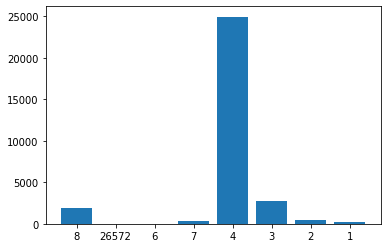

In [9]:
import matplotlib.pyplot as plt

plt.bar(list(sample_count.keys()), list(sample_count.values()))
sample_count

<Figure size 2000x1600 with 0 Axes>

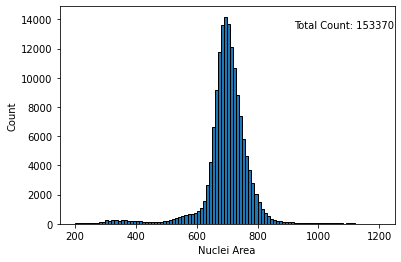

<Figure size 2000x1600 with 0 Axes>

In [9]:
nuclei_area = features[:, 1178]
plt.hist(nuclei_area, bins=100, range=(200, 1200), edgecolor='black')
plt.xlabel("Nuclei Area")
plt.ylabel("Count")
plt.annotate(f'Total Count: {len(nuclei_area)}', xy=(0.7, 0.9), xycoords='axes fraction')
plt.figure(figsize=(10, 8), dpi=200)

In [14]:
nuclei_area.min()

80.0